In [1]:
%matplotlib inline

import numpy as np
import scipy as scp
import re
import os
import sys
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import matplotlib.pyplot as plt
import itertools

# adding project folder to lib search path
project = "/".join((os.path.split(os.getcwd())[0], os.path.split(os.getcwd())[1], 'scripts'))
if project not in sys.path:
    sys.path.append(project)

In [2]:
project

'C:\\Users\\Supper\\Desktop\\some codes (do not move it)/hiv_project/scripts'

In [3]:
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
def preparing_data(haplo_seq_dict, days):
    patt = r'_[\d]*_'
    seq_dict = {} 
    seq_name_days_dict = {x:[] for x in days}
    for obj in haplo_seq_dict:
        seq_dict[obj['desc']]=obj['seq']
        res = re.search(patt, obj['desc'])
        if res != None:
            seq_name_days_dict[re.search(patt, obj['desc']).group(0).replace('_','')].append(obj['desc'])
        else:
            pass
    return seq_dict, seq_name_days_dict

def translating_seqs(seq_dict):
    prot_dict = {}
    for key in seq_dict:
        prot_dict[key] = translate_dna(seq_dict[key], '-')
    return prot_dict

In [89]:
codon_table = {'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
              'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
              'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
              'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
              'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
              'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
              'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
              'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
              'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
              'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
              'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
              'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
              'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
              'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
              'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
              'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
              '---': '-',
              }

def translate_dna(seq, gap):
    global codon_table
    prot = []
    res = ''
    for x in seq:
        if x == gap:
            continue
        res += x
        if len(res) == 3:
            if res in codon_table:
                prot.append(codon_table[res])
                res = ''
            else:
                prot.append('X')
                res = ''
    return ''.join(prot)

In [27]:
haplo_seq_dict, days = download.read_fasta('data/fasta/hivevo_p2_V3.fasta')
seq_dict, seq_name_days_dict = preparing_data(haplo_seq_dict, days)
prot_dict = translating_seqs(seq_dict)

### Hydro / n(SNP)

In [71]:
import pandas as pd

hydro_df = pd.read_csv('hydrophobicity.csv', index_col = None)
hydro_df
hydro_fact = dict(zip(list(hydro_df['aa']),list(hydro_df['Kyte-Doolittle'])))
hydro_fact['X'] = 0 # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!11  added
hydro_fact['*'] = 0
hydro_fact['-'] = 0

In [ ]:
def calculating_snp(seq1, seq2):
    """
    Function to calculate SNP in two sequences
    Args:
        seq1: string
        seq2: string
    Return:
        snp: int, num of SNPs
    """
    aligner = Align.PairwiseAligner()
    score = aligner.score(seq1, seq2)
    snp = len(seq1) - score
    '''n = len(seq1)
    m = len(seq2)
    if m > n:
        n, m = m, n
        seq1, seq2 = seq2, seq1
    seq2 += ' '*(n-m)
    
    snp = 0
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            snp += 1'''
    return snp


snp_dict = {day:[] for day in days}
ref_seq = seq_dict['reference']
for day in seq_name_days_dict.keys():
    for seq_name in seq_name_days_dict[day]:
        snp_dict[day].append(calculating_snp(ref_seq, seq_dict[seq_name]))

In [106]:
def calculate_metric(seq):
    """
    Function to calculate hydrophobicity for DNA sequence
    Args:
        seq: string, sequnce to translate
    Return:
        res: float, metric result
    """
    prot = translate_dna(seq, gap='-')
    
    res = 0
    
    for aa in prot:
        res += hydro_fact[aa]
    
    return res

In [110]:
patients

['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11']

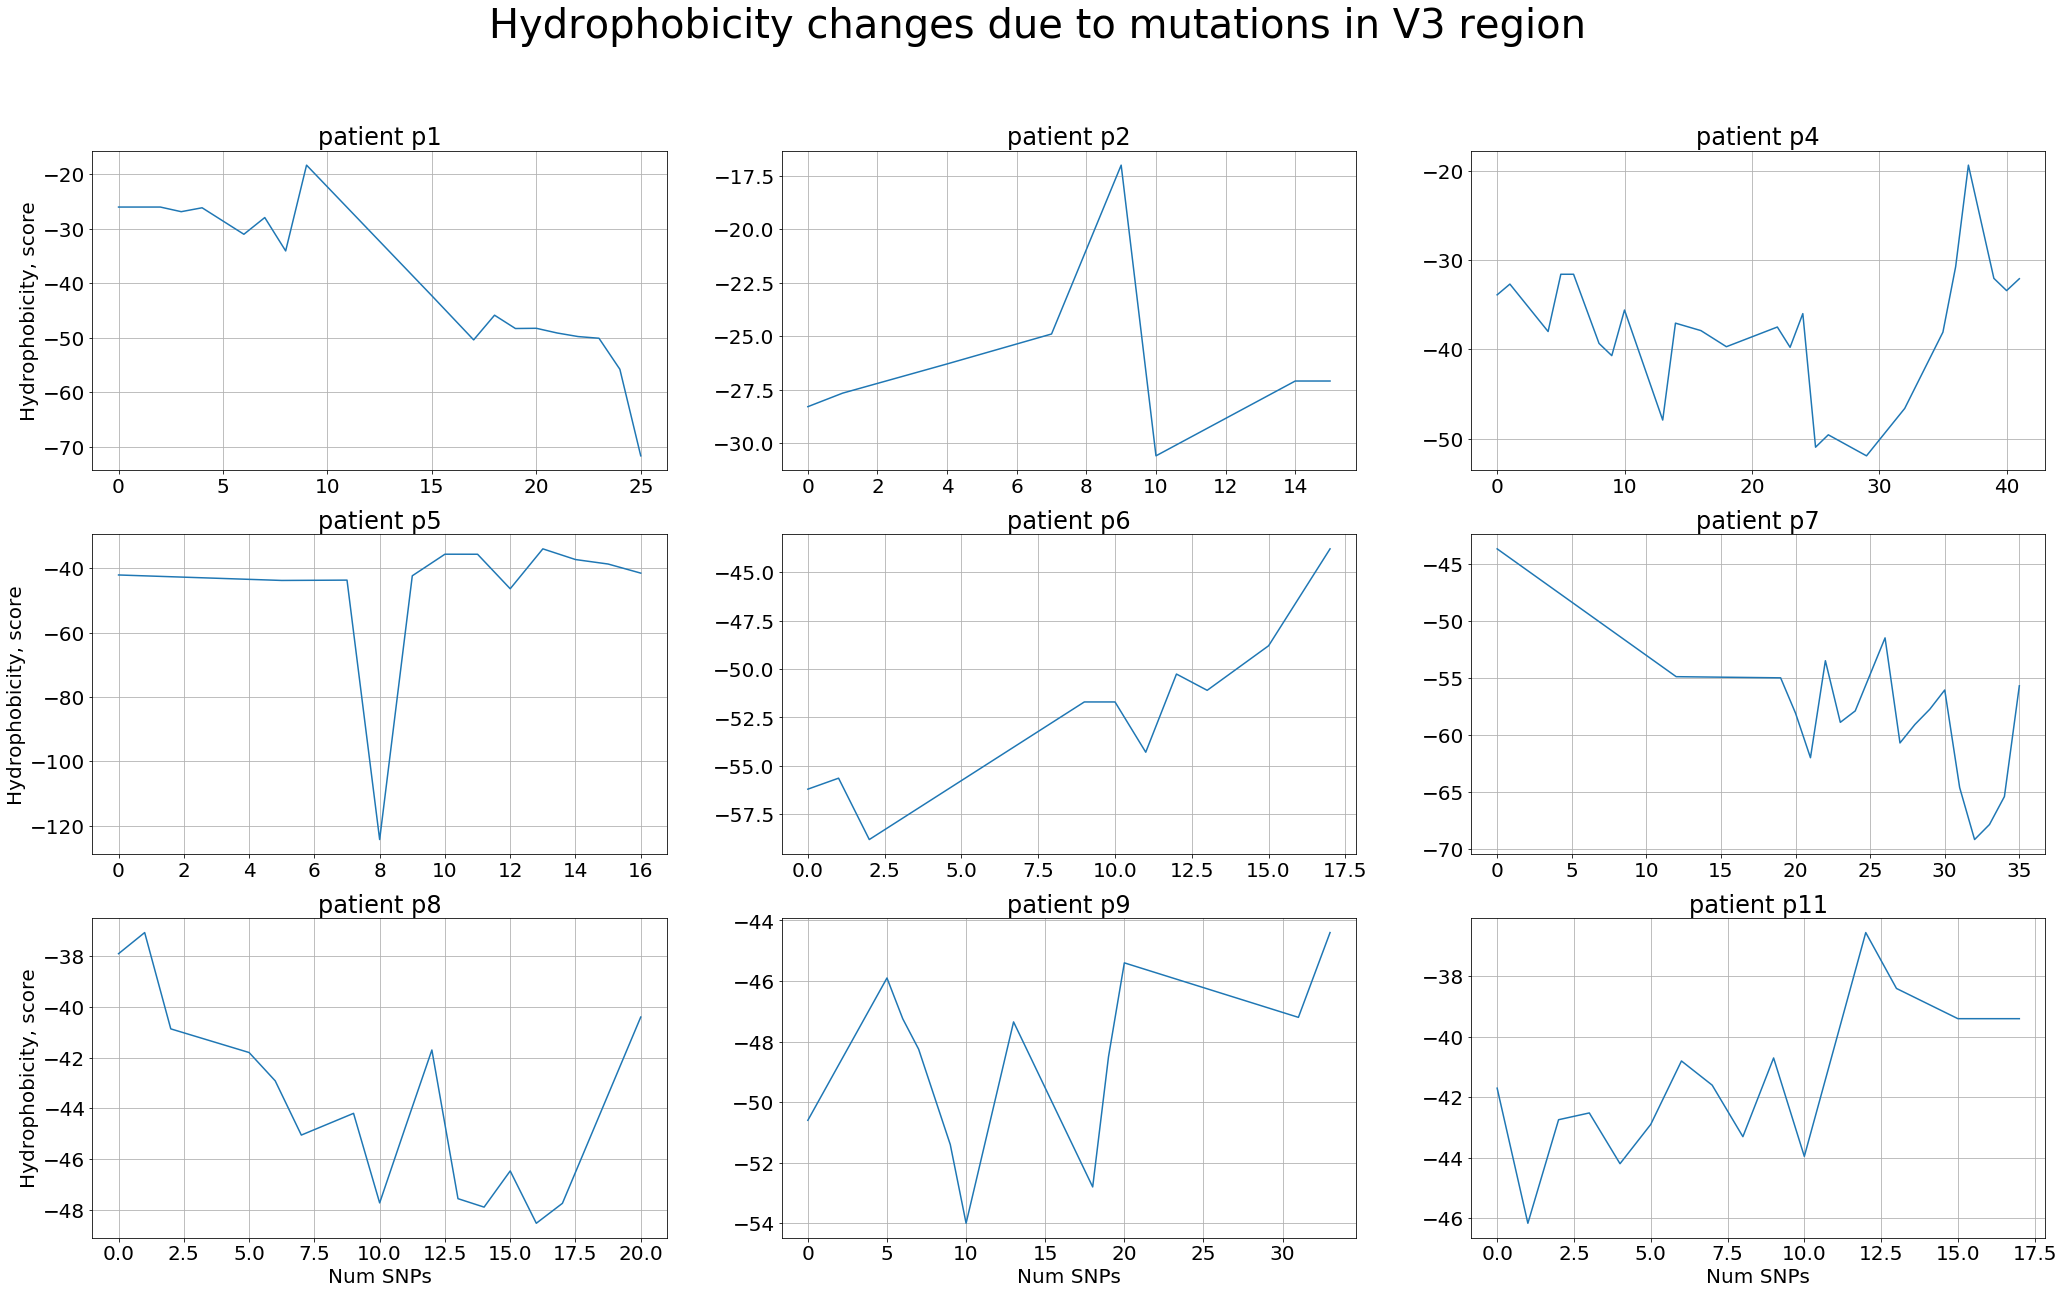

In [131]:
# All this function are to make graphs

def hydro_snp(seq_name_days_dict, seq_dict):
    """ Make X and Y for graph SNPs -> X, Hydro_metric -> Y"""
    snp_hydro_dict = {}
    ref_seq = seq_dict['reference']

    snp_hydro_dict[0] = [calculate_metric(ref_seq)]
    for day in seq_name_days_dict.keys():
        for seq_name in seq_name_days_dict[day]:
            snp = calculating_snp(ref_seq, seq_dict[seq_name])
            if snp not in snp_hydro_dict:
                snp_hydro_dict[snp] = []
            snp_hydro_dict[snp].append(calculate_metric(seq_dict[seq_name]))

    X = []
    Y = []

    for snp in sorted(snp_hydro_dict.keys()):
        X.append(snp)
        Y.append(np.array(snp_hydro_dict[snp]).mean())
    
    return X, Y

def pat_snp(patients):
    """ Who know how does this work? """
    pat_X, pat_Y = [], []
    
    for patient in patients:
        if patient != 'p3' and patient != 'p10':
            haplo_seq_dict, days = download.read_fasta('data/fasta/hivevo_{}_V3.fasta'.format(patient))
            #print(days)
            seq_dict, seq_name_days_dict = preparing_data(haplo_seq_dict, days)
            prot_dict = translating_seqs(seq_dict)
        
            X, Y = hydro_snp(seq_name_days_dict, seq_dict)
        
            pat_X.append(X)
            pat_Y.append(Y)
    
    return pat_X, pat_Y

pat_X, pat_Y = pat_snp(patients)

fig, axs = plt.subplots(3, 3, figsize = (35, 20), sharex = 'none', sharey = 'none')
#fig.figsize = (20, 16)
i = 0
for x in range(3):
    for y in range(3):
        axs[x, y].plot(pat_X[i], pat_Y[i])
        axs[x, y].set_title('patient {}'.format(patients_used[i]))
        axs[x, y].grid()
        i += 1
            
            
#print(list(axs.flat))

axs[0, 0].set(ylabel='Hydrophobicity, score')
axs[1, 0].set(ylabel='Hydrophobicity, score')
axs[2, 0].set(ylabel='Hydrophobicity, score')

axs[2, 0].set(xlabel='Num SNPs')
axs[2, 1].set(xlabel='Num SNPs')
axs[2, 2].set(xlabel='Num SNPs')

#for ax in axs.flat:
    #ax.set(xlabel='time, days', ylabel='Prob to be human prot, %')

'''for ax in axs.flat:
    ax.label_outer()'''

#plt.tick_params(axis='both', which='both', labelsize=7)
fig.suptitle('Hydrophobicity changes due to mutations in V3 region', fontsize = 40)
plt.savefig('graphs_hydro.png', quality=100, bbox_inches='tight')
plt.show()

### 2-mer

In [7]:
# Function to create graphs for 2-mers analyze

amino_string = 'ARNDCQEGHILKMFPSTWYV'

def making_subseq(k):
    '''Making all subsequences using aminoacids'''
    subseq_iter = itertools.product(amino_string, repeat = k)
    subseq_list = list(subseq_iter)
    del subseq_iter
    for i in range(len(subseq_list)):
        tup = subseq_list[i]
        subseq_list[i] = ''.join(tup)
    return subseq_list

def occurrences_count(string, sub):
    '''
    Counting all ocurrances of substring in string using find() method
    variables:
        string - string where to find
        sub - string to find
    '''
    count = start = 0
    while True:
        start = string.find(sub, start) + 1
        if start > 0:
            count+=1
        else:
            return count

def finding_freq_single_protein(seq):
    
    '''Finding frequnces for subsequences in single protein
    and scaling it with SKlearn StandardScaler()
    return vector_freq'''
    subseq_list = making_subseq(2)
    n = len(seq)
    k = len(subseq_list[0])
    
    vector_freq = []
    
    for x in subseq_list:
        vector_freq.append(float(occurrences_count(seq, x))/n)
    
    vector_freq = np.array(vector_freq)
    vector_freq = vector_freq.reshape((-1, 1))
    scaler = preprocessing.StandardScaler()
    vector_freq_scaled = scaler.fit_transform(vector_freq)
    del vector_freq
    
    return list(vector_freq_scaled)

def clf_metric_2_mer_path(path, prot_dict):
    metric_path = []
    for name in path:
        metric_path.append([])
        prot = prot_dict[name]
        tmp = finding_freq_single_protein(prot)
        for x in tmp:
            metric_path[-1].append(float(x[0]))
        
    return metric_path

In [8]:
# Our classificator

forest_2_mer = load('saved_sklearn_models/forest.joblib')

In [9]:
# Making font BIGGER!

plt.rcParams['font.size'] = 20

In [116]:
patients = ['p{}'.format(i) for i in range(1, 12)]
patients

['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11']

In [117]:
def graph_patients(patients):
    """
    Function to prepare Xs and Ys for plotting
    """
    pat_X = []
    pat_Y = []
    
    patients_used = []
    for patient in patients:
        if patient != 'p3' and patient != 'p10':
            haplo_seq_dict, days = download.read_fasta('data/fasta/hivevo_{}_V3.fasta'.format(patient))
            print(days)
            seq_dict, seq_name_days_dict = preparing_data(haplo_seq_dict, days)
            prot_dict = translating_seqs(seq_dict)
            
            #print(days)
            
            phylo_tree = Phylo_tree()
            phylo_tree.construct_levels(days)
            phylo_tree.constructing_tree(seq_dict, seq_name_days_dict)
            phylo_paths = phylo_tree.create_all_path()
        
            X = list(map(int, days))
            X.insert(0, 0)
            pat_X.append(X)
            pat_Y.append([])
        
            for path in phylo_paths:
                met = clf_metric_2_mer_path(path, prot_dict)
                Y = forest_2_mer.predict_proba(met)[:, 1]
                pat_Y[-1].append(Y)
            
            patients_used.append(patient)
    return pat_X, pat_Y, patients_used

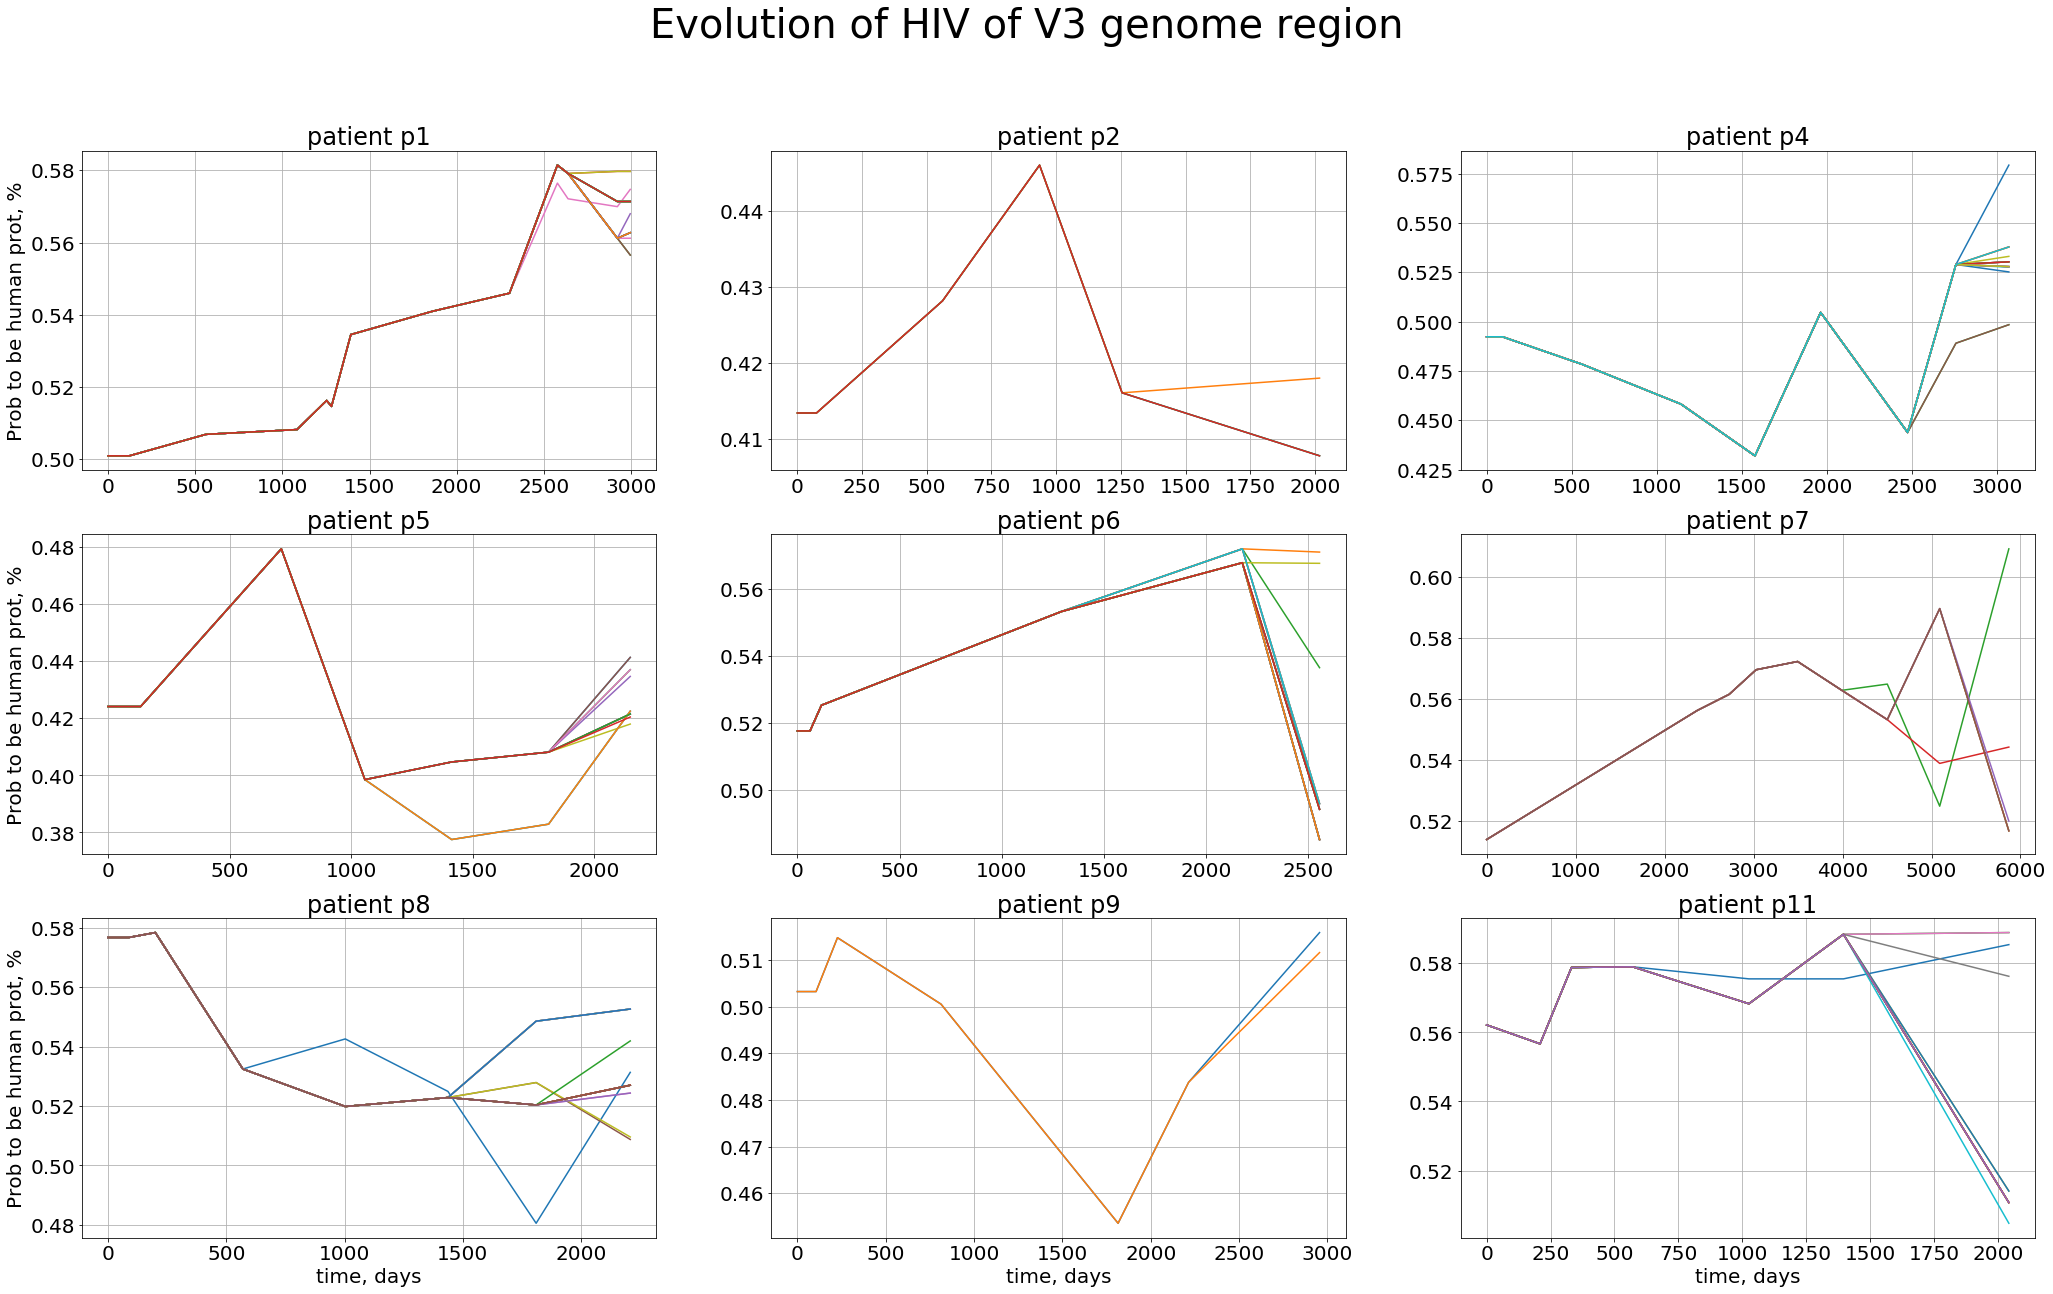

In [123]:
# Plotting

fig, axs = plt.subplots(3, 3, figsize = (35, 20), sharex = 'none', sharey = 'none')
#fig.figsize = (20, 16)
i = 0
for x in range(3):
    for y in range(3):
        for Y in pat_Y[i]:
            axs[x, y].plot(pat_X[i], Y)
            axs[x, y].set_title('patient {}'.format(patients_used[i]))
        axs[x, y].grid(alpha=1)
        i += 1
            
            
#print(list(axs.flat))

axs[0, 0].set(ylabel='Prob to be human prot, %')
axs[1, 0].set(ylabel='Prob to be human prot, %')
axs[2, 0].set(ylabel='Prob to be human prot, %')

axs[2, 0].set(xlabel='time, days')
axs[2, 1].set(xlabel='time, days')
axs[2, 2].set(xlabel='time, days')

#for ax in axs.flat:
    #ax.set(xlabel='time, days', ylabel='Prob to be human prot, %')

'''for ax in axs.flat:
    ax.label_outer()'''

#plt.tick_params(axis='both', which='both', labelsize=7)
fig.suptitle('Evolution of HIV of V3 genome region', fontsize = 40)
plt.savefig('graphs.png', quality=100, bbox_inches='tight')
plt.show()